In [20]:
import csv
import numpy
import networkx as nx
import matplotlib.pyplot as plt
import copy
import time

In [21]:
M_vector=numpy.array([1000,2000,3000,4000,5000])
tran_max=500
water_filling_packet=5

# Importing Ripple Data 

- Graph
- Transactions

In [23]:
#Importing the set of edges
bi_edges=numpy.loadtxt("ripple_graph.txt",dtype=int)
bi_edges=numpy.unique(bi_edges,axis=0)

#Making a graph from the given set of edges
wei=numpy.ones(len(bi_edges)) #initializing the weights of the edges
bi_G = nx.DiGraph() #Initializing the directed graph
for i in range(0,len(bi_edges)):
    bi_G.add_weighted_edges_from([(bi_edges[i,0], bi_edges[i,1],wei[i])]) #adding edges to the graph and assigning weights

#Importing Transactions
with open('transactions.csv') as csvDataFile:
    tran=csv.reader(csvDataFile)
    tran=list(tran) #converting the imported data into a list
    tran=numpy.array(tran) #converting the list into numpy array
tran=numpy.ndarray.astype(tran,float)
k=0
for i in range(0,len(tran)):
    if tran[i,2]>tran_max:
        tran=numpy.delete(tran,obj=i,axis=0) #removing all the transactions that are greater than tran_max
    k=k+1
    if len(tran)<k:
        break

# Finding the minimum weighted path in a given graph G from s to d

- Using the Heuristic: Find K- Shortest path using the positive part of the weights and pick the path among these which has the lowest total weight

In [24]:
def minwp_heu(G,s,d,tran,K): 
    X=nx.shortest_simple_paths(G,s,d,'imbalance') 
    #returns a generator which returns one path at a time from shortest to longest
    weight2=100000 #initialize by a very large number
    for j, path in enumerate(X): #enumerate shortest to longest paths 
        weight1=0 #initialize by 0 to calculate the weight of path
        for k in range(0,len(path)-1):
            weight1=weight1+G[path[k]][path[k+1]]['weight']-G[path[k+1]][path[k]]['weight'] 
            #calculating the actual weight of path p
        if min(weight1,weight2)==weight1 and weight1!=weight2: #comparing with the best weight obtained so far
            min_wei_path=path #picking the minimum weight path
            weight2=weight1 #updating the best weight obtained so for
        if j == K-1: #break after looking at K shortest paths according to the imbalance
            break
    var=1
    for l in range(0,len(min_wei_path)-1):
        s=min(G[min_wei_path[l]][min_wei_path[l+1]]['weight'],G[min_wei_path[l+1]][min_wei_path[l]]['weight'],M)
        if G[min_wei_path[l]][min_wei_path[l+1]]['weight']+tran-s>M: 
            #Checking if a has enough capacity to route tran
            var=0
    if var!=0:
        return min_wei_path #We will either get a path from s to d or 0 if min_wei_path cannot route tran
    else:
        return 0

# Routing Tran using path

In [25]:
def UpdateWeights(G,path,tran):
    for i in range(0,len(path)-1):
        s=min(G[path[i]][path[i+1]]['weight'],G[path[i+1]][path[i]]['weight'],M) #calculating the amount of service
        G[path[i]][path[i+1]]['weight']=G[path[i]][path[i+1]]['weight']+tran-s
        G[path[i+1]][path[i]]['weight']=G[path[i+1]][path[i]]['weight']-s
        bi_G[path[i]][path[i+1]]['imbalance']=max(bi_G[path[i]][path[i+1]]['weight']
            -bi_G[path[i+1]][path[i]]['weight'],0)#initializing the weights
        bi_G[path[i+1]][path[i]]['imbalance']=max(bi_G[path[i+1]][path[i]]['weight']
            -bi_G[path[i]][path[i+1]]['weight'],0) #initializing the weights
    return G

# Main Loop

In [28]:
for argument in range(0,len(M_vector)):
    M=M_vector[argument]
    no_of_succ_tran=0
    amount_of_succ_tran=0
    total_buffer=0
    min_wei_path=0
    for k in range(0,len(bi_edges)):
        bi_G[bi_edges[k,0]][bi_edges[k,1]]['weight']=0.01/len(bi_edges) #initializing the weights
        bi_G[bi_edges[k,0]][bi_edges[k,1]]['imbalance']=0 #initializing the imbalance
    for i in range(0,len(tran)):
        if min_wei_path!=0:
            bi_G=UpdateWeights(bi_G,min_wei_path,0) #Balancing the outstanding balance from prev transaction
            #Ideally, you would clear out the buffer on all the edges but we do it only for the edges for which 
            #there can be some outstanding balance to optimize the run time of the code
        min_wei_path=minwp_heu(bi_G,tran[i,0],tran[i,1],float(tran[i,2]),1) #finding the minimum weighted path from sender to reciever
        if min_wei_path!=0: #If a path exists
            bi_G=UpdateWeights(bi_G,min_wei_path,tran[i,2]) #Route the transaction using min_wei_path
            no_of_succ_tran=no_of_succ_tran+1
            amount_of_succ_tran=amount_of_succ_tran+tran[i,2]
    for i in range(0,len(bi_edges)):
        total_buffer=total_buffer+bi_G[bi_edges[i,0]][bi_edges[i,1]]['weight']
    f = open("max_weight_heu.txt","a+")
    f.write('------------------------------------')
    f.write("\r\n")
    f.write("no_of_succ_tran =%f," %no_of_succ_tran)
    f.write("\r\n")
    f.write("amount_of_succ_tran=%f" %amount_of_succ_tran)
    f.write("\r\n")
    f.write("total_buffer = %f," %total_buffer)
    f.write("\r\n")
    f.write("M = %f," %M)
    f.write("\r\n")
    f.write('------------------------------------')
    f.write("\r\n")
    f.close()

# Water Filling
- Using minwp_heu to find the shortest weighted path but divide the transaction by water_filling _packet and route each one of them seperately
- UpdateWeights is replaced by AddWeights and Balancing as we first AddWeights to all the multiple paths and then balance all the outstanding balance together

In [29]:
def AddWeights(G,path,tran,d):
    for i in range(0,len(path)-1):
        if path[i]!=d:
            G[path[i]][path[i+1]]['weight']=G[path[i]][path[i+1]]['weight']+tran
            bi_G[path[i]][path[i+1]]['imbalance']=max(bi_G[path[i]][path[i+1]]['weight']
                -bi_G[path[i+1]][path[i]]['weight'],0)
            bi_G[path[i+1]][path[i]]['imbalance']=max(bi_G[path[i+1]][path[i]]['weight']
                -bi_G[path[i]][path[i+1]]['weight'],0) 
    return G

In [30]:
def Balancing(G,path,d):
    for i in range(0,len(path)-1):
        if path[i]!=d:
            s=min(G[path[i]][path[i+1]]['weight'],G[path[i+1]][path[i]]['weight'],M) #calculating the amount of service
            G[path[i]][path[i+1]]['weight']=G[path[i]][path[i+1]]['weight']-s
            G[path[i+1]][path[i]]['weight']=G[path[i+1]][path[i]]['weight']-s
            bi_G[path[i]][path[i+1]]['imbalance']=max(bi_G[path[i]][path[i+1]]['weight']
                -bi_G[path[i+1]][path[i]]['weight'],0)
            bi_G[path[i+1]][path[i]]['imbalance']=max(bi_G[path[i+1]][path[i]]['weight']
                -bi_G[path[i]][path[i+1]]['weight'],0) 
    return G

# Water Filling

In [31]:
for argument in range(0,len(M_vector)):
    M=M_vector[argument]
    no_of_succ_tran=0
    amount_of_succ_tran=0
    total_buffer=0
    min_wei_path=0
    for k in range(0,len(bi_edges)):
        bi_G[bi_edges[k,0]][bi_edges[k,1]]['weight']=0 #initializing the weights
        bi_G[bi_edges[k,0]][bi_edges[k,1]]['imbalance']=0 #initializing the imbalance
    for i in range(0,len(tran)):
        path_list=[] #to consolidate all the paths chosen to route a transaction
        min_wei_path=0
        var=1
        transaction=tran[i,2]/water_filling_packet #dividing the transaction into water_filling_packet number of packets
        for j in range(0,water_filling_packet):
            min_wei_path=minwp_heu(bi_G,tran[i,0],tran[i,1],transaction,1) 
            #finding the minimum weighted path from sender to reciever
            if min_wei_path!=0: #If a path exists
                bi_G=AddWeights(bi_G,min_wei_path,transaction,tran[i,1]) #Add the transaction to min_wei_path
                path_list.extend(min_wei_path) #add the path to the path list
            else:
                var=0 #even if partial transaction fails, abort the whole transaction
                if path_list!=[]:
                    bi_G=AddWeights(bi_G,path_list,-transaction,tran[i,1]) 
                    #remove the transaction that was added to the graph
                break
        if var!=0: #if the whole transaction went through
            bi_G=Balancing(bi_G,path_list,tran[i,1]) #balance the outstanding transaction
            no_of_succ_tran=no_of_succ_tran+1 #update the number of successful transactions
            amount_of_succ_tran=amount_of_succ_tran+tran[i,2] #update the amount of successful transactions
    for i in range(0,len(bi_edges)):
        total_buffer=total_buffer+bi_G[bi_edges[i,0]][bi_edges[i,1]]['weight'] 
        #output the total imbalance in the network
    f = open("Blockchain/water_filling.txt","a+")
    f.write('------------------------------------')
    f.write("\r\n")
    f.write("no_of_succ_tran =%f," %no_of_succ_tran)
    f.write("\r\n")
    f.write("amount_of_succ_tran=%f" %amount_of_succ_tran)
    f.write("\r\n")
    f.write("total_buffer = %f," %total_buffer)
    f.write("\r\n")
    f.write("M = %f," %M)
    f.write("\r\n")
    f.write('------------------------------------')
    f.write("\r\n")
    f.close()

# Plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


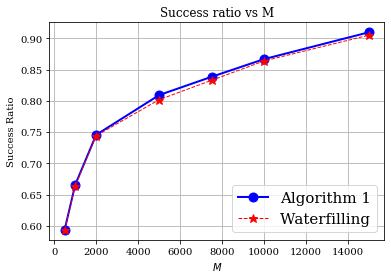

In [16]:
import matplotlib.pyplot as plt
import numpy
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Computer Modern']
x=numpy.array([500,1000,2000,5000,7500,10000,15000])
y=numpy.array([24662,27621,30940,33575,34785,35957,37737])
z=numpy.array([24642,27542,30883,33270,34553,35837,37546])
#w=numpy.array([53487,77930,89219,93451,94119])
plt.figure(1)
plt.plot(x,y/len(tran),'bo-', label='Algorithm 1', linewidth=2, markersize=9)
plt.plot(x, z/len(tran), 'r*--',label='Waterfilling', linewidth=1, markersize=9)
#plt.plot(x, w/len(tran), 'g*-',label='Algorithm 1 + Heuristic', linewidth=1, markersize=9)
plt.xlabel('$M$')
plt.ylabel('Success Ratio')
plt.title('Success ratio vs M')
plt.grid(True)
plt.legend(loc=4,prop={'size': 15})
plt.savefig("success_ratio.eps")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


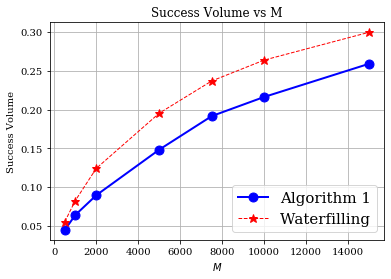

In [17]:
import matplotlib.pyplot as plt
import numpy
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Computer Modern']
x=numpy.array([500,1000,2000,5000,7500,10000,15000])
y=numpy.array([767410,1098996,1538857,2553272,3299446,3725784,4463882])
z=numpy.array([949925,1419162,2136250,3364531,4081269,4545652,5164917])
#w=numpy.array([53487,77930,89219,93451,94119])
plt.figure(1)
plt.plot(x,y/sum(tran[:,2]),'bo-', label='Algorithm 1', linewidth=2, markersize=9)
plt.plot(x, z/sum(tran[:,2]), 'r*--',label='Waterfilling', linewidth=1, markersize=9)
#plt.plot(x, w/len(tran), 'g*-',label='Algorithm 1 + Heuristic', linewidth=1, markersize=9)
plt.xlabel('$M$')
plt.ylabel('Success Volume')
plt.title('Success Volume vs M')
plt.grid(True)
plt.legend(loc=4,prop={'size': 15})
plt.savefig("success_volume.eps")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


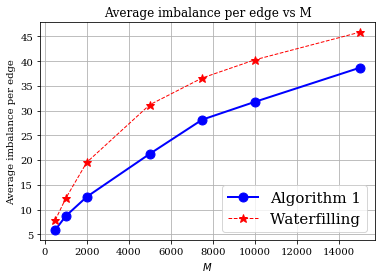

In [18]:
import matplotlib.pyplot as plt
import numpy
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Computer Modern']
x=numpy.array([500,1000,2000,5000,7500,10000,15000])
y=numpy.array([1171774,1733533,2507866,4242105,5623456,6339356,7716080])
z=numpy.array([1569894,2449758,3900621,6224259,7305645,8036684,9151589])
#w=numpy.array([53487,77930,89219,93451,94119])
plt.figure(1)
plt.plot(x,y/len(bi_edges),'bo-', label='Algorithm 1', linewidth=2, markersize=9)
plt.plot(x, z/len(bi_edges), 'r*--',label='Waterfilling', linewidth=1, markersize=9)
#plt.plot(x, w/len(tran), 'g*-',label='Algorithm 1 + Heuristic', linewidth=1, markersize=9)
plt.xlabel('$M$')
plt.ylabel('Average imbalance per edge')
plt.title('Average imbalance per edge vs M')
plt.grid(True)
plt.legend(loc=4,prop={'size': 15})
plt.savefig("imbalance.eps")
plt.show()